In [6]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib
import cartopy.crs as ccrs
import scipy.stats as sts

import os
import pickle

import SAM
import cluster_utils as flt

import importlib
importlib.reload(SAM)
importlib.reload(flt)

from dask import delayed

In [10]:
model_folder = 'model'
data_folder = 'data'
n_classes = 5
ids = ['r1i1p1f2', 'r3i1p1f2', 'r2i1p1f2', 'r8i1p1f2', 'r4i1p1f2', 'r5i1p1f3', 'r7i1p1f3', 'r9i1p1f2', 'r6i1p1f3', 'r10i1p1f2']
#ids = ['r1i1p1f2', 'r2i1p1f2', 'r3i1p1f2', 'r4i1p1f2', 'r8i1p1f2', 'r9i1p1f2', 'r10i1p1f2']
#ids = ['r1i1p1f2']
mask = np.load('data/mask.npy', allow_pickle=True)

Starting r1i1p1f2
Finished setup for r1i1p1f2
Starting r3i1p1f2
Finished setup for r3i1p1f2
Starting r2i1p1f2
Finished setup for r2i1p1f2
Starting r8i1p1f2
Finished setup for r8i1p1f2
Starting r4i1p1f2
Finished setup for r4i1p1f2
Starting r5i1p1f3
Finished setup for r5i1p1f3
Starting r7i1p1f3
Finished setup for r7i1p1f3
Starting r9i1p1f2
Finished setup for r9i1p1f2
Starting r6i1p1f3
Finished setup for r6i1p1f3
Starting r10i1p1f2
Finished setup for r10i1p1f2
Done!


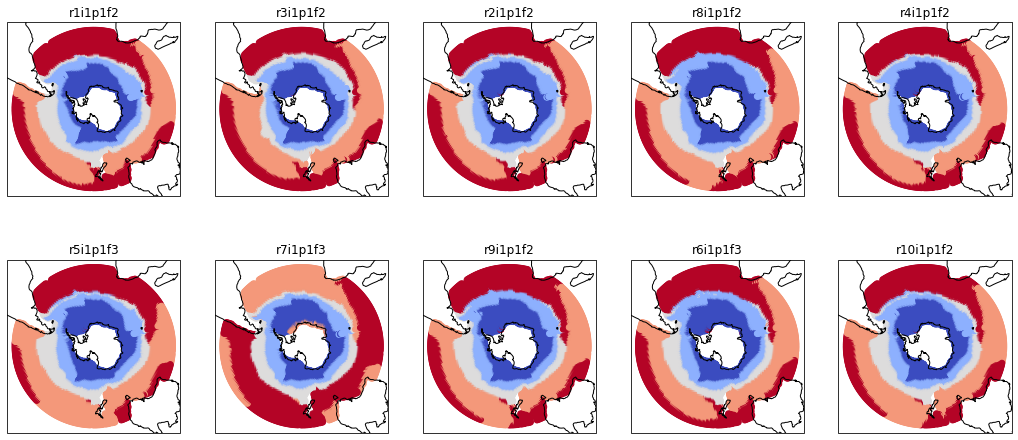

In [11]:
# Reference
avg_profiles_dict = {}
path_ref = '{}/{}/{}'.format(data_folder, ids[0], n_classes)
with open('{}/avg.obj'.format(path_ref), 'rb') as file:
  ref_profiles = pickle.load(file)
  file.close()
inds = flt.temp_sort(None, ref_profiles, True)
ref_profiles = [ref_profiles[x] for x in inds]

plt.figure(figsize=[18,8])

for (m_i, m_id) in enumerate(ids):

  print('Starting {}'.format(m_id))
  path_id = '{}/{}'.format(model_folder, m_id)
  path_n = '{}/{}/{}'.format(model_folder, m_id, n_classes)
  path_d = '{}/{}/{}'.format(data_folder, m_id, n_classes)

#  with open('{}/pca.obj'.format(path_id), 'rb') as file:
#      pca = pickle.load(file)
#      file.close()
#
#  with open('{}/gmm.obj'.format(path_n), 'rb') as file:
#      gmm = pickle.load(file)
#      file.close()

  with open('{}/avg.obj'.format(path_d), 'rb') as file:
      avg_profiles = pickle.load(file)
      file.close()

#  options = {'memberId' : m_id, 'raw' : True}
#  data = flt.retrieve_profiles(timeRange = slice('1965-01', '1994-12'), mask=mask, options=options)
#  data_sampled = flt.normalise_data(data, ('i', 'j', 'time'))
#  data_trans = flt.pca_transform(data_sampled, pca)
#  data_c = flt.gmm_classify(data_trans, gmm)
#  data_c_modal=flt.modal_classes(data_c)
  data_c_modal=xr.open_dataarray('{}/modal_classes.nc'.format(path_n))
  
  #inds = flt.match_profiles(ref_profiles, avg_profiles)
  inds=flt.temp_sort(data_c_modal, avg_profiles,arg=True)
  data_c_modal = flt.reorder(data_c_modal, inds).compute()
 # data_c_modal=flt.temp_sort(data_c_modal, avg_profiles)
  
  avg_profiles = [avg_profiles[x] for x in inds]
  avg_profiles_dict[m_id] = avg_profiles
  print('Finished setup for {}'.format(m_id))
  
  # Make a plot
  
  lats = data_c_modal['lat'].values
  lons = data_c_modal['lon'].values
  #lev = data['lev'].values

  plt_data = data_c_modal.values
#  alpha = np.logical_not(data.isel(time=0, lev=-1).isnull().values)
  #alpha = np.isin(data_c.isel(time=0).values, (3, 4, 5))
  plt_data[plt_data == -1] = np.nan
 # for i in range(np.size(plt_data, 0)):
 #     print(i)
  ax = plt.subplot(2, 5, m_i+1, projection=ccrs.SouthPolarStereo())
 # ax.pcolormesh(lons, lats, plt_data, transform=ccrs.PlateCarree(), alpha=alpha, cmap='coolwarm')
  ax.scatter(lons,lats,c=plt_data, transform=ccrs.PlateCarree(), cmap='coolwarm')
  ax.coastlines()
  ax.set_title(m_id)
  ax.set_facecolor('white')
   
print('Done!')

plt.savefig('figures/1965-1995-mode_{}classes'.format(m_id,n_classes), dpi=600)
plt.show()
#ax.clear()

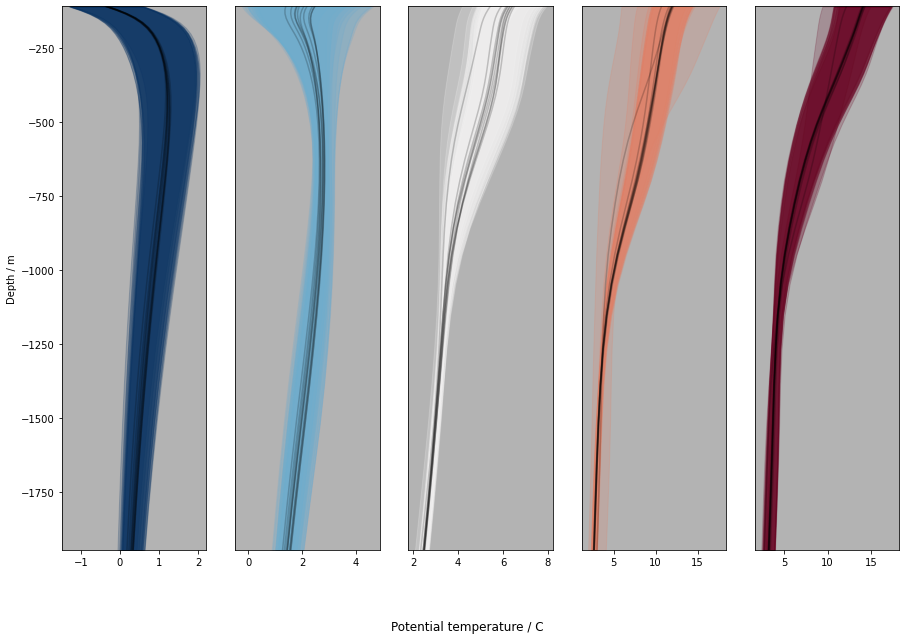

In [12]:
options = {'memberId' : m_id, 'raw' : True}
data = flt.retrieve_profiles(timeRange = '1999-01', mask=mask, options=options)
lev=data.lev

cmap = matplotlib.cm.get_cmap('RdBu_r')
fig, axes = plt.subplots(1, n_classes)
for (m_i, m_id) in enumerate(ids):
#m_id='r1i1p1f2'
    for (n, ax) in enumerate(axes):
        if n > 0:
          ax.set_yticks([])
        else:
          ax.set_ylabel('Depth / m')
        ax.plot(avg_profiles_dict[m_id][n]['mean'], -lev, c='black', alpha=0.2)
        x1 = avg_profiles_dict[m_id][n]['mean'] + avg_profiles_dict[m_id][n]['std']
        x2 = avg_profiles_dict[m_id][n]['mean'] - avg_profiles_dict[m_id][n]['std']
        ax.plot(x1, -lev, c='black', ls='--', alpha=0.0)
        ax.plot(x2, -lev, c='black', ls='--', alpha=0.0)
        ax.fill_betweenx(-lev, x1, x2, color=cmap(n / (n_classes - 1)), alpha=0.2)

        #ax.set_xlabel('Potential temperature / C')
        ax.set_ylim(np.min(-lev), np.max(-lev))
        ax.set_facecolor((0.7, 0.7, 0.7, 1))
    
fig.supxlabel('Potential temperature / C')
fig.set_size_inches(3 * n_classes, 10)
plt.savefig('figures/profiles-{}classes'.format(n_classes), dpi=300)